In [36]:
# run_with_new_generator_star.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# Typography / plot style (legends are mechanism names only)
mpl.rc('font', family='serif', serif=['Times New Roman'])
mpl.rcParams.update({
    'text.usetex': False,
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 30

# --- NEW: data utilities (star model) ---
from data_utils_newest import (
    gen_star_from_x1,       # <-- star/hub generator
    get_true_frequencies,
)

# --- baselines ---
from metrics import compute_mse
from spl import random_split_perturb, random_split_estimate
from rs_fd import rs_fd_perturb, rs_fd_estimate
from rs_rfd import rs_rfd_perturb, rs_rfd_estimate

from corr_rr_fixed_new import (
    corr_rr_phase1_spl,
    corr_rr_phase2_perturb,
    corr_rr_estimate,
    combine_phase_estimates,
    optimal_p_y,
    build_p_y_table,
)

# ---------------- helpers ----------------
def _normalize_dist(d):
    vals = np.array([max(0.0, float(v)) for v in d.values()], dtype=float)
    s = vals.sum()
    if s <= 0:
        k = len(vals)
        vals = np.full(k, 1.0 / k)
    else:
        vals = vals / s
    return {k: vals[i] for i, k in enumerate(d.keys())}

def _build_p_y_table_minimal(est_I, epsilon, n2, domain, cols):
    return {
        (a, b): float(optimal_p_y(est_I[a], est_I[b], epsilon, n2, domain))
        for a in cols for b in cols if a != b
    }

# ---------------- one-shot runner ----------------
def run_all_once(
    df,
    epsilon,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    cols = list(df.columns)
    domains = {c: sorted(df[c].unique().tolist()) for c in cols}
    true_freqs = get_true_frequencies(df, cols)

    out = {}

    # --- SPL (one-phase random split + perturb) ---
    rpt = random_split_perturb(df, epsilon)
    est = random_split_estimate(rpt, df, epsilon)
    out["SPL"] = np.mean([compute_mse(true_freqs[c], est[c]) for c in cols])

    # --- RS+FD (one-phase random sampling + fake data) ---
    pert_rsfd = rs_fd_perturb(df, domains, epsilon)
    est_rsfd = rs_fd_estimate(pert_rsfd, domains, epsilon)
    out["RS+FD"] = np.mean([compute_mse(true_freqs[c], est_rsfd[c]) for c in cols])

    # --- RS+RFD (two-phase; Phase I via SPL to learn priors, Phase II uses RFD) ---
    est_I_rsrfd, df_B_rsrfd, doms_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_rsrfd)
    n1_rsrfd = len(df) - len(df_B_rsrfd)
    n2_rsrfd = len(df_B_rsrfd)
    priors_2p = {col: _normalize_dist(est_I_rsrfd[col]) for col in est_I_rsrfd}
    pert_rsrfd_2p = rs_rfd_perturb(df_B_rsrfd, doms_rsrfd, priors_2p, epsilon)
    est_II_rsrfd = rs_rfd_estimate(pert_rsrfd_2p, doms_rsrfd, priors_2p, epsilon)
    combined_rsrfd = combine_phase_estimates(est_I_rsrfd, est_II_rsrfd, n1_rsrfd, n2_rsrfd)
    out["RS+RFD"] = np.mean([compute_mse(true_freqs[c], combined_rsrfd[c]) for c in cols])

    # --- Corr-RR (two-phase) ---
    if use_corr_rr:
        est_I, df_B, doms_stable = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_corr)
        n1 = len(df) - len(df_B)
        n2 = len(df_B)
        common_domain = doms_stable[cols[0]]
        p_y_table = _build_p_y_table_minimal(est_I, epsilon, n2, common_domain, cols)
        pert_corr = corr_rr_phase2_perturb(df_B, epsilon, est_I, doms_stable, p_y_table)
        est_II = corr_rr_estimate(pert_corr, doms_stable, epsilon)
        combined_est = combine_phase_estimates(est_I, est_II, n1, n2)
        out["Corr-RR"] = np.mean([compute_mse(true_freqs[c], combined_est[c]) for c in cols])

    return out

def sweep_vs_phase1(
    n=10000,
    epsilon=0.8,                  # hold epsilon fixed while sweeping Phase I fraction
    R=50,
    corr=0.9,                     # rho for star model: Xj copies X1 with prob corr
    d=4,
    domain=None,
    x1_marginal=None,             # None => uniform on domain
    q_marginal=None,              # None => uniform for non-copy branch
    plot_dir=None,
    csv_dir=None,
    seed=None,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
):
    """
    Star model data:
      - X1 ~ x1_marginal over `domain`
      - For j >= 2: Xj = X1 w.p. corr; else ~ q_marginal (or uniform if None)
    X-axis: Phase I user fraction (|A|/n). Y-axis: MSE.
    Curves: SPL, RS+FD, RS+RFD, Corr-RR.
    """
    if domain is None:
        domain = [0, 1]

    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(fractions)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    attr_count = d
    domain_size = len(domain)

    for run in range(R):
        # One dataset per run; reused across all fractions
        df = gen_star_from_x1(
            n=n,
            domain=domain,
            d=d,
            x1_marginal=x1_marginal,
            rho=corr,
            q_marginal=q_marginal,
            seed=None if seed is None else (seed + run + int(1000 * corr)),
        )

        for j, frac in enumerate(fractions):
            res = run_all_once(
                df,
                epsilon,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac,     # Corr-RR Phase I fraction
                frac_phase1_rsrfd=frac,    # RS+RFD Phase I fraction
            )
            for k in keys:
                means[k][j] += res[k]

    # Average over runs
    for k in keys:
        means[k] /= R

    # -------- Plot (keep your exact sizes; only legend layout changed) --------
    plt.figure(figsize=(10, 8))
    x_vals = [int(100 * f) for f in fractions]

    plt.plot(x_vals, means["SPL"],    '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(x_vals, means["RS+FD"],  '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(x_vals, means["RS+RFD"], '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(x_vals, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

    plt.xlabel('Users in Phase I (%)', fontsize=40)
    plt.ylabel('MSE', fontsize=40)
    plt.xticks(x_vals, labels=[f"{x}" for x in x_vals])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    # Legend at top center, stacked in rows (2 columns => 2 rows for 4 items)
    plt.legend(
        fontsize=35,
        loc='upper center',
        ncol=2,
        frameon=True,
        edgecolor='black',
        bbox_to_anchor=(0.5, 1.33),
        labelspacing=0.01,      # vertical space between rows (default 0.5)
        columnspacing=1.0,     # horizontal space between columns (default 2.0)
        handletextpad=0.8,     # space between marker and text (default 0.8)
        handlelength=2       # length of the line symbol (default 2.0)
    )

    # Make a bit of room for the legend above without changing font sizes
    plt.tight_layout()
    plt.subplots_adjust(top=0.82)

    # Filenames
    def _fmt(x): return f"{x:g}"
    base = f"mseVSphase1_{attr_count}attr_{domain_size}domain_n_{n}_eps_{_fmt(epsilon)}_rho_{_fmt(corr)}"

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, base + ".pdf"), format="pdf")

    plt.show()

    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        df_out = pd.DataFrame({"phase1_pct": x_vals})
        for k in keys:
            df_out[k] = means[k]
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    print("Users in Phase I (%) =", x_vals)
    for k in keys:
        print(f"{k} MSE =", means[k])

    return means




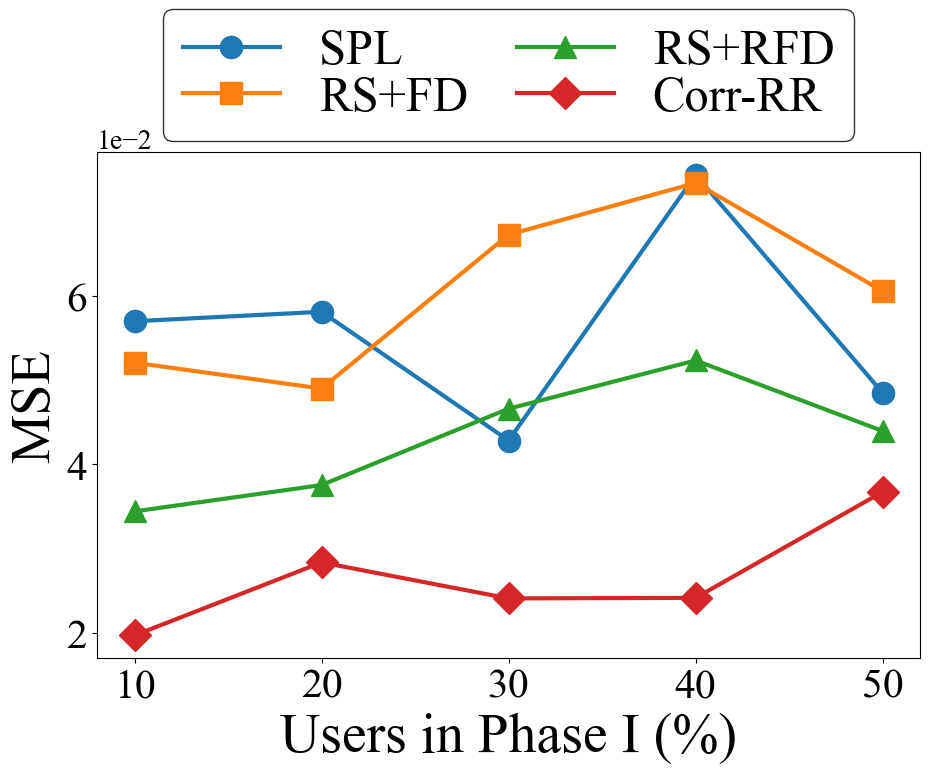

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.05701818 0.05813983 0.04284465 0.07439228 0.04852209]
RS+FD MSE = [0.05208922 0.0490159  0.06729859 0.07344877 0.06059867]
RS+RFD MSE = [0.03442009 0.03755128 0.04662177 0.05235772 0.0439763 ]
Corr-RR MSE = [0.01968437 0.02836006 0.02408341 0.02414673 0.03673598]


In [41]:
means = sweep_vs_phase1(
    n=20000,
    epsilon=0.1,            # pick the ε you want to hold fixed
    R=10,
    corr=0.1,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    #plot_dir="plots",
    #csv_dir="csvs",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


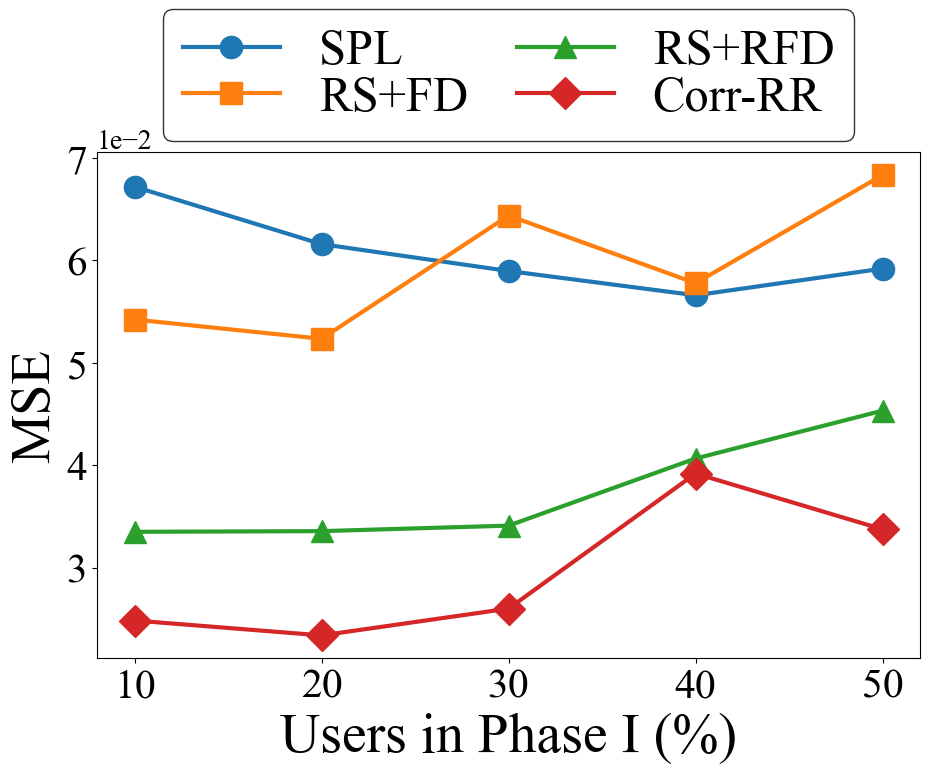

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.06718511 0.0615782  0.05895387 0.05658684 0.05918716]
RS+FD MSE = [0.05421788 0.05233531 0.06437037 0.05776486 0.06832619]
RS+RFD MSE = [0.03349104 0.03355615 0.03409429 0.04064825 0.04532165]
Corr-RR MSE = [0.0248302  0.02337605 0.02599149 0.03918056 0.03373624]


In [44]:
means = sweep_vs_phase1(
    n=20000,
    epsilon=0.1,            # pick the ε you want to hold fixed
    R=50,
    corr=0.9,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    #plot_dir="plots",
    #csv_dir="csvs",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


In [60]:
def sweep_vs_phase1(
    n=10000,
    epsilon=0.8,                  # hold epsilon fixed while sweeping Phase I fraction
    R=50,
    corr=0.9,                     # rho for star model: Xj copies X1 with prob corr
    d=4,
    domain=None,
    x1_marginal=None,             # None => uniform on domain
    q_marginal=None,              # None => uniform for non-copy branch
    plot_dir=None,
    csv_dir=None,
    seed=None,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
):
    """
    Star model data:
      - X1 ~ x1_marginal over `domain`
      - For j >= 2: Xj = X1 w.p. corr; else ~ q_marginal (or uniform if None)
    X-axis: Phase I user fraction (|A|/n). Y-axis: MSE.
    Curves: SPL, RS+FD, RS+RFD, Corr-RR.

    Optimization: SPL and RS+FD are single-phase. For a fixed dataset, their
    MSEs don't depend on the Phase-I fraction. We therefore compute them only
    for the first x-value per run and reuse that value across the remaining x-values.
    """
    if domain is None:
        domain = [0, 1]

    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(fractions)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    attr_count = d
    domain_size = len(domain)

    for run in range(R):
        # One dataset per run; reused across all fractions
        df = gen_star_from_x1(
            n=n,
            domain=domain,
            d=d,
            x1_marginal=x1_marginal,
            rho=corr,
            q_marginal=q_marginal,
            seed=None if seed is None else (seed + run + int(1000 * corr)),
        )

        # Cache single-phase results (computed only once at j==0)
        cached_single_phase = {}

        for j, frac in enumerate(fractions):
            res = run_all_once(
                df,
                epsilon,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac,     # Corr-RR Phase I fraction
                frac_phase1_rsrfd=frac,    # RS+RFD Phase I fraction
            )

            # --- RS+RFD and Corr-RR: accumulate at every x-value as usual ---
            if "RS+RFD" in keys:
                means["RS+RFD"][j] += res["RS+RFD"]
            if "Corr-RR" in keys and use_corr_rr:
                means["Corr-RR"][j] += res["Corr-RR"]

            # --- SPL & RS+FD: compute once (j==0) per run, then reuse ---
            if "SPL" in keys:
                if j == 0:
                    cached_single_phase["SPL"] = res["SPL"]
                means["SPL"][j] += cached_single_phase["SPL"]
            if "RS+FD" in keys:
                if j == 0:
                    cached_single_phase["RS+FD"] = res["RS+FD"]
                means["RS+FD"][j] += cached_single_phase["RS+FD"]

    # Average over runs
    for k in keys:
        means[k] /= R

    # -------- Plot (keep your exact sizes; only legend layout is custom) --------
    plt.figure(figsize=(10, 8))
    x_vals = [int(100 * f) for f in fractions]

    plt.plot(x_vals, means["SPL"],    '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(x_vals, means["RS+FD"],  '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(x_vals, means["RS+RFD"], '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(x_vals, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

    plt.xlabel('Users in Phase I (%)', fontsize=40)
    plt.ylabel('MSE', fontsize=40)
    plt.xticks(x_vals, labels=[f"{x}" for x in x_vals])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    # Legend at top center, 2 columns (=> 2 rows for 4 items). Tweak spacing as needed.
    plt.legend(
        fontsize=35,
        loc='upper center',
        ncol=2,
        frameon=True,
        edgecolor='black',
        bbox_to_anchor=(0.50, 1.33),
        labelspacing=0.01,   # vertical space between rows
        columnspacing=1.0,   # horizontal space between columns
        handletextpad=0.8,   # space between marker and text
        handlelength=2       # line symbol length
    )

    # Make room for the legend above without changing fonts
    plt.tight_layout()
    plt.subplots_adjust(top=0.82)

    # Filenames
    def _fmt(x): return f"{x:g}"
    base = f"mseVSphase1_{attr_count}attr_{domain_size}domain_n_{n}_eps_{_fmt(epsilon)}_rho_{_fmt(corr)}"

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, base + ".pdf"), format="pdf")

    plt.show()

    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        df_out = pd.DataFrame({"phase1_pct": x_vals})
        for k in keys:
            df_out[k] = means[k]
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    print("Users in Phase I (%) =", x_vals)
    for k in keys:
        print(f"{k} MSE =", means[k])

    return means


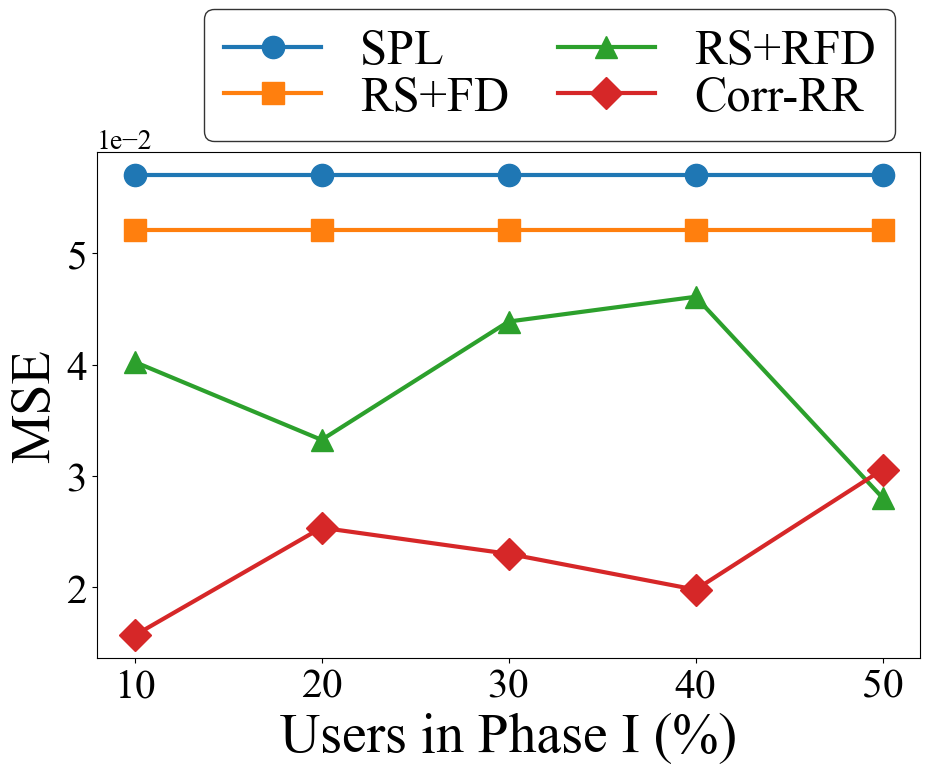

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.05701818 0.05701818 0.05701818 0.05701818 0.05701818]
RS+FD MSE = [0.05208922 0.05208922 0.05208922 0.05208922 0.05208922]
RS+RFD MSE = [0.04024093 0.03323784 0.04386044 0.04608753 0.02803639]
Corr-RR MSE = [0.01568199 0.02535347 0.0230055  0.01978966 0.03057515]


In [50]:
means = sweep_vs_phase1(
    n=20000,
    epsilon=0.1,            # pick the ε you want to hold fixed
    R=10,
    corr=0.1,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    #plot_dir="plots",
    #csv_dir="csvs",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


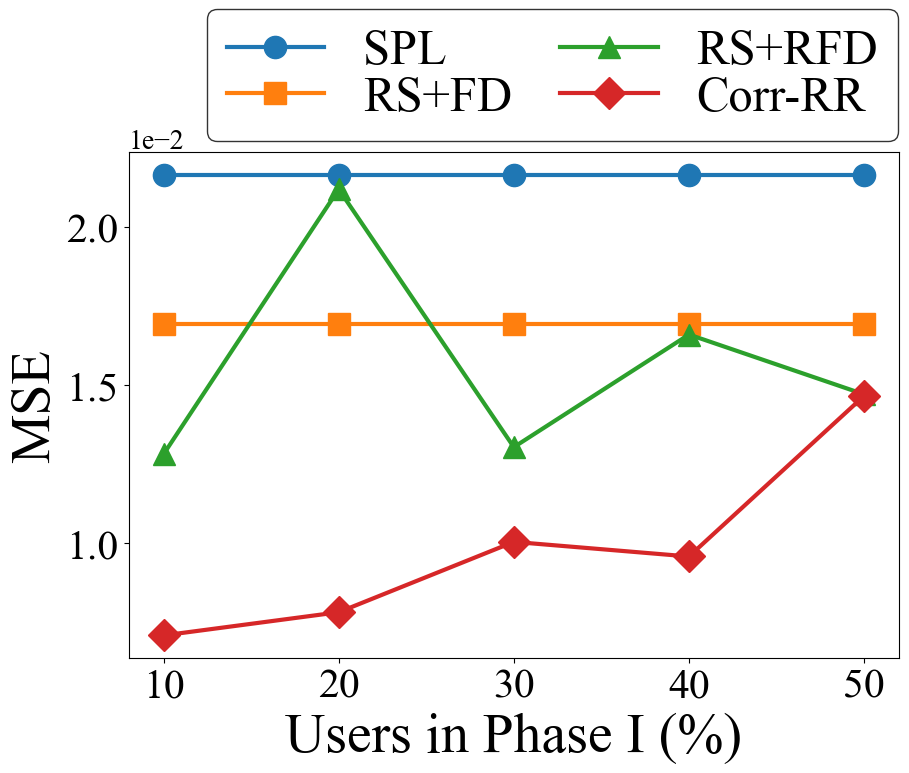

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.02163477 0.02163477 0.02163477 0.02163477 0.02163477]
RS+FD MSE = [0.0169234 0.0169234 0.0169234 0.0169234 0.0169234]
RS+RFD MSE = [0.01281861 0.02118631 0.01304112 0.01659741 0.01470956]
Corr-RR MSE = [0.0070966  0.00782834 0.01004971 0.00958861 0.01466045]


In [58]:
means = sweep_vs_phase1(
    n=2000,
    epsilon=0.5,            # pick the ε you want to hold fixed
    R=20,
    corr=0.1,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    #plot_dir="plots",
    #csv_dir="csvs",
    seed=41,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


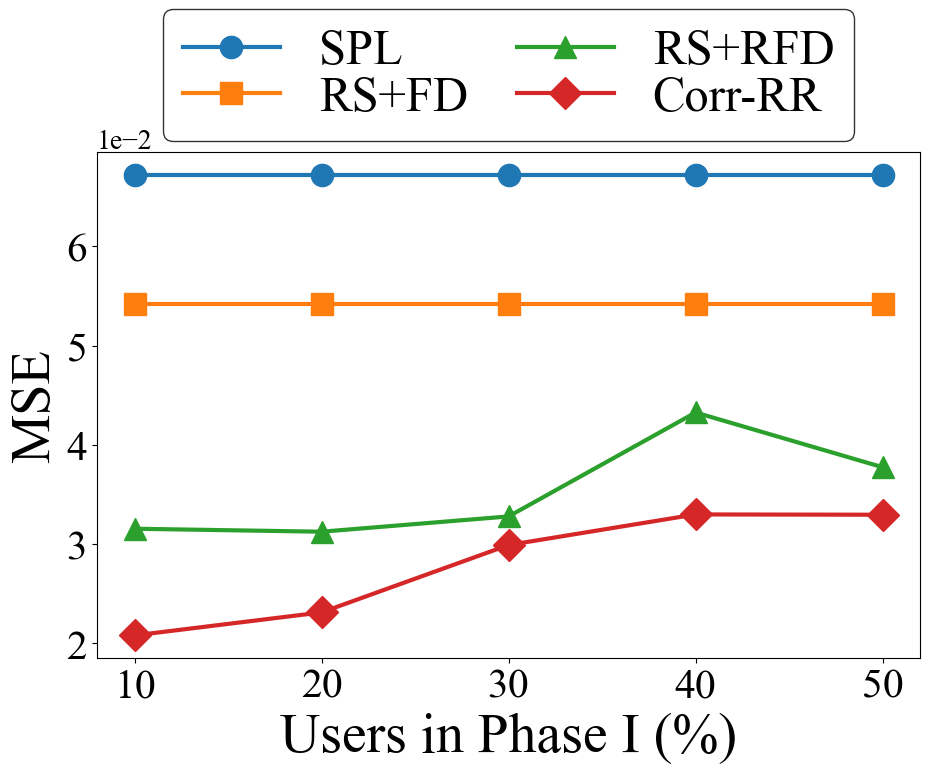

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.06718511 0.06718511 0.06718511 0.06718511 0.06718511]
RS+FD MSE = [0.05421788 0.05421788 0.05421788 0.05421788 0.05421788]
RS+RFD MSE = [0.03155648 0.031257   0.03279666 0.04326458 0.03774966]
Corr-RR MSE = [0.02081159 0.02312902 0.02991559 0.03299614 0.03296595]


In [62]:
means = sweep_vs_phase1(
    n=20000,
    epsilon=0.1,            # pick the ε you want to hold fixed
    R=50,
    corr=0.9,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
    csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


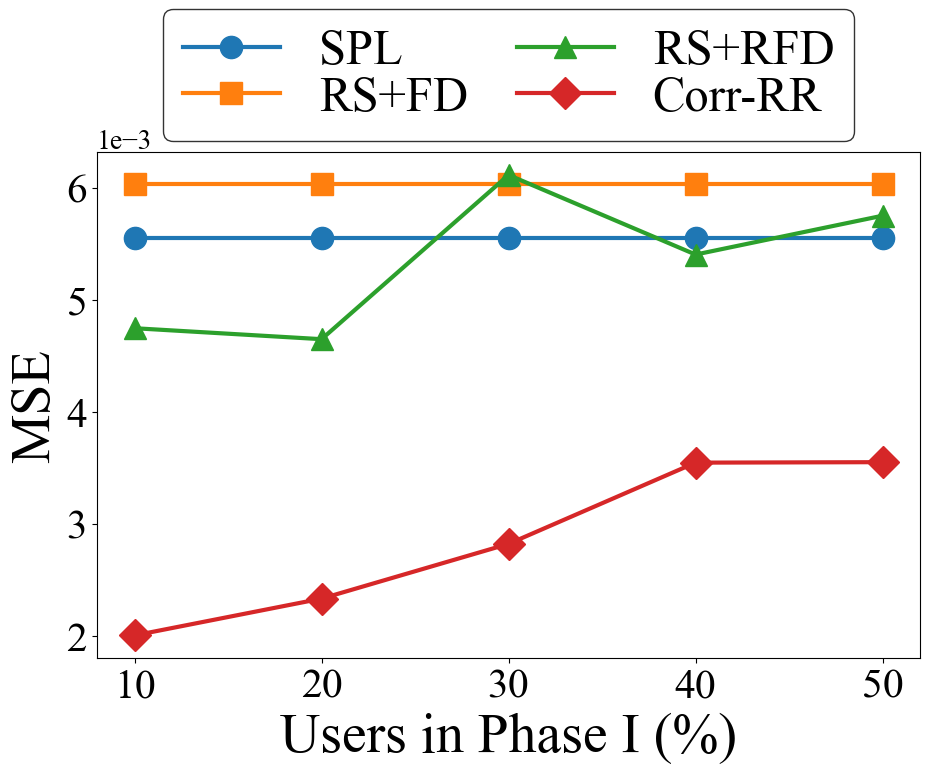

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.00555145 0.00555145 0.00555145 0.00555145 0.00555145]
RS+FD MSE = [0.00602987 0.00602987 0.00602987 0.00602987 0.00602987]
RS+RFD MSE = [0.00474362 0.00464572 0.00611148 0.00540133 0.00574829]
Corr-RR MSE = [0.00200092 0.00232941 0.00281814 0.00354345 0.00354768]


In [63]:
means = sweep_vs_phase1(
    n=20000,
    epsilon=0.3,            # pick the ε you want to hold fixed
    R=50,
    corr=0.9,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
    csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


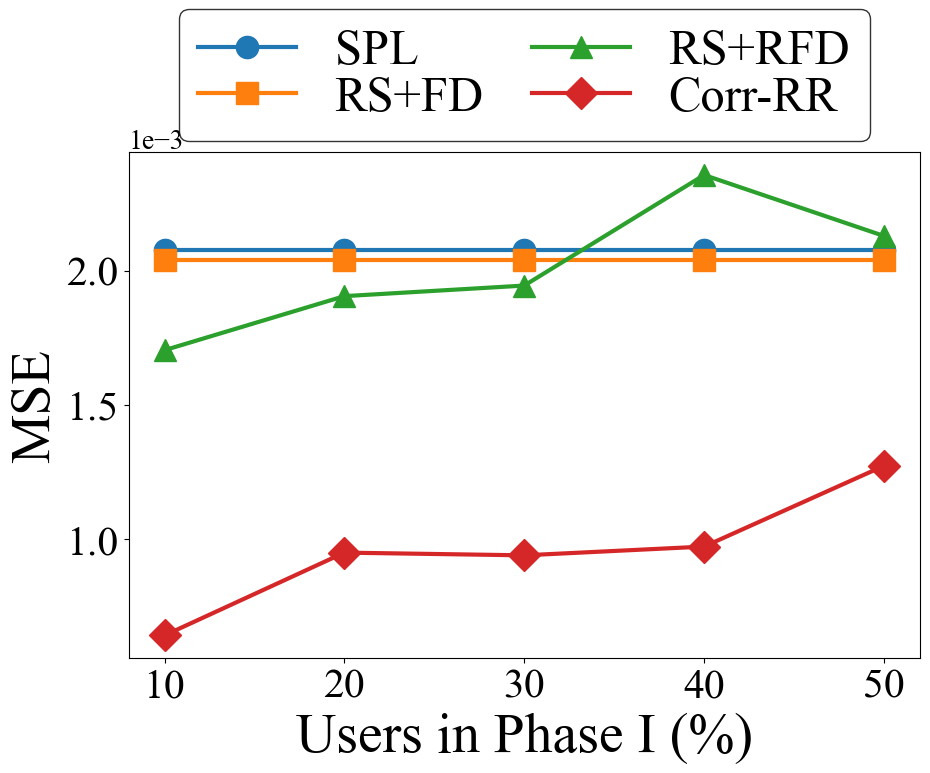

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.00207687 0.00207687 0.00207687 0.00207687 0.00207687]
RS+FD MSE = [0.00204093 0.00204093 0.00204093 0.00204093 0.00204093]
RS+RFD MSE = [0.00170312 0.00190452 0.00194395 0.00235593 0.00212874]
Corr-RR MSE = [0.00064012 0.00094862 0.0009385  0.00097119 0.00127225]


In [64]:
means = sweep_vs_phase1(
    n=20000,
    epsilon=0.5,            # pick the ε you want to hold fixed
    R=50,
    corr=0.9,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
    csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


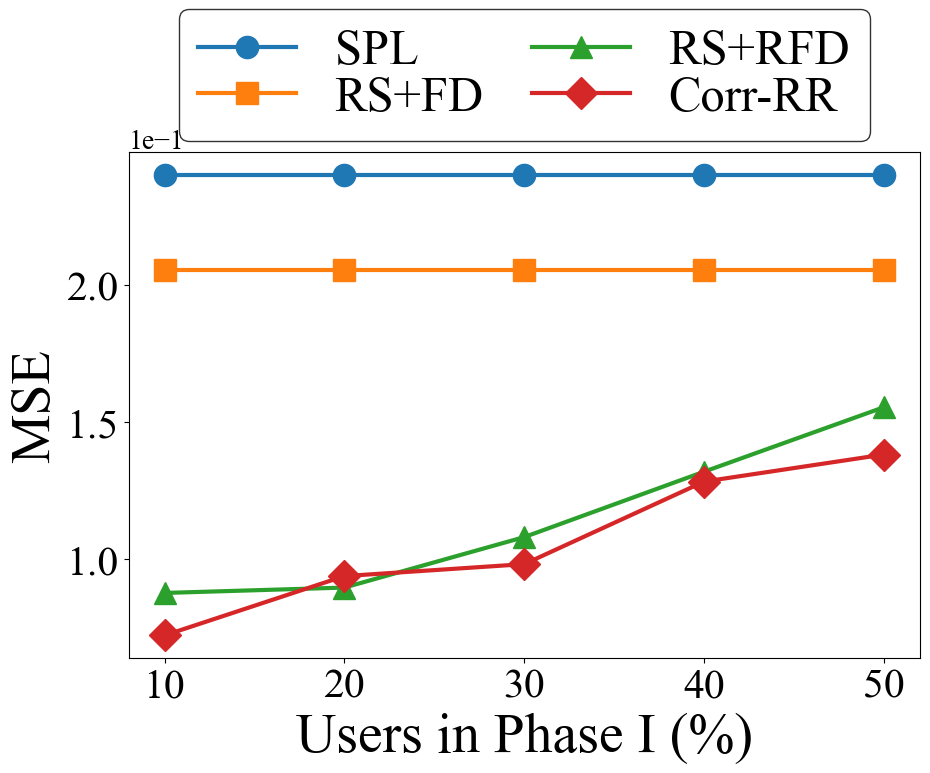

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.24014518 0.24014518 0.24014518 0.24014518 0.24014518]
RS+FD MSE = [0.20529892 0.20529892 0.20529892 0.20529892 0.20529892]
RS+RFD MSE = [0.0875905  0.08955519 0.10798321 0.13186506 0.15540749]
Corr-RR MSE = [0.07209371 0.09374944 0.09811062 0.128248   0.13812272]


In [77]:
means = sweep_vs_phase1(
    n=5000,
    epsilon=0.1,            # pick the ε you want to hold fixed
    R=50,
    corr=0.9,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
    csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


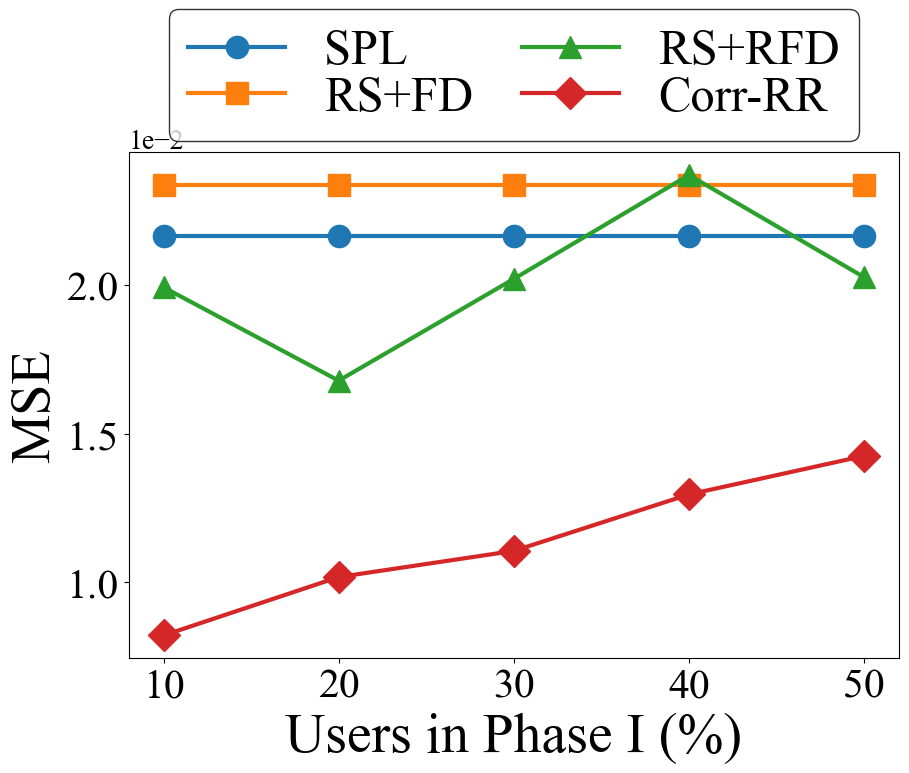

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.0216554 0.0216554 0.0216554 0.0216554 0.0216554]
RS+FD MSE = [0.02336382 0.02336382 0.02336382 0.02336382 0.02336382]
RS+RFD MSE = [0.0199309  0.01678898 0.02021387 0.02370948 0.02027063]
Corr-RR MSE = [0.00821502 0.01017896 0.01105863 0.01295941 0.01425646]


In [78]:
means = sweep_vs_phase1(
    n=5000,
    epsilon=0.3,            # pick the ε you want to hold fixed
    R=50,
    corr=0.9,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
    csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


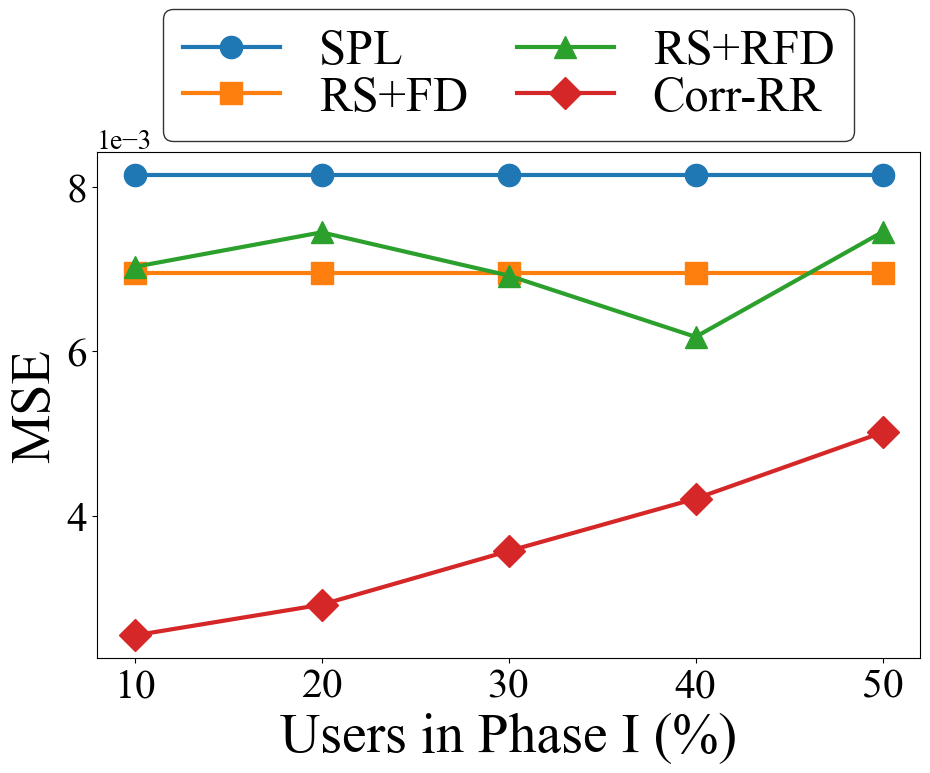

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.00814749 0.00814749 0.00814749 0.00814749 0.00814749]
RS+FD MSE = [0.00695179 0.00695179 0.00695179 0.00695179 0.00695179]
RS+RFD MSE = [0.00702869 0.00744932 0.006923   0.00617592 0.0074543 ]
Corr-RR MSE = [0.00253968 0.0029141  0.00356716 0.0042053  0.00501262]


In [79]:
means = sweep_vs_phase1(
    n=5000,
    epsilon=0.5,            # pick the ε you want to hold fixed
    R=50,
    corr=0.9,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
    csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


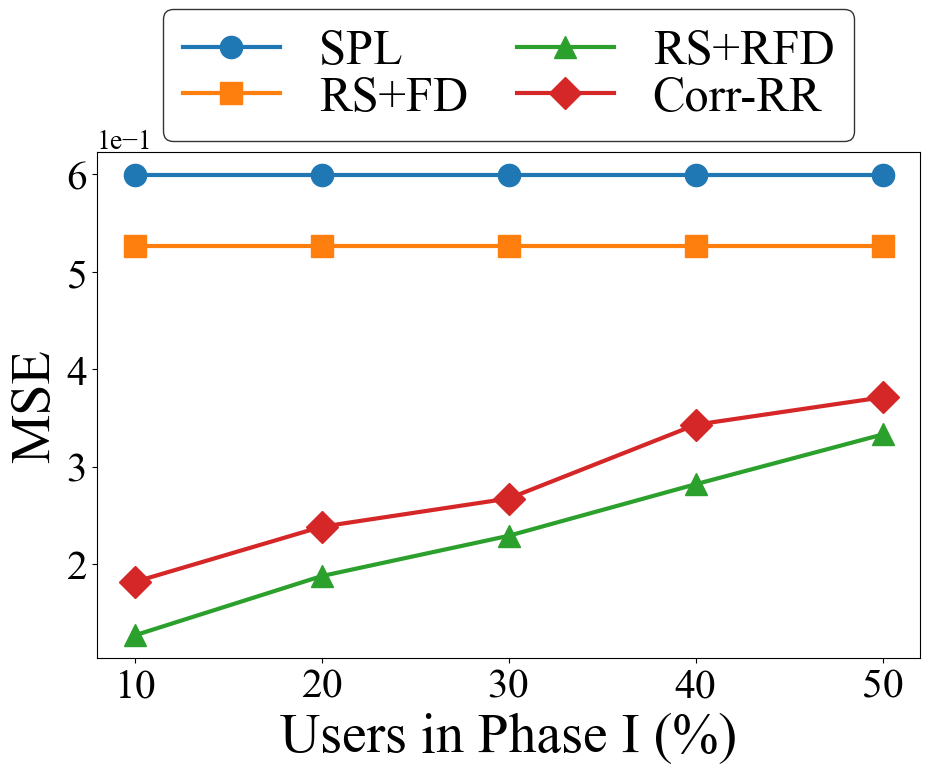

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.59943475 0.59943475 0.59943475 0.59943475 0.59943475]
RS+FD MSE = [0.5270075 0.5270075 0.5270075 0.5270075 0.5270075]
RS+RFD MSE = [0.12665816 0.18755106 0.22893847 0.28189534 0.33299065]
Corr-RR MSE = [0.18152006 0.2382362  0.26723152 0.3429987  0.37120092]


In [93]:
means = sweep_vs_phase1(
    n=2000,
    epsilon=0.1,            # pick the ε you want to hold fixed
    R=200,
    corr=0.9,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
    csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


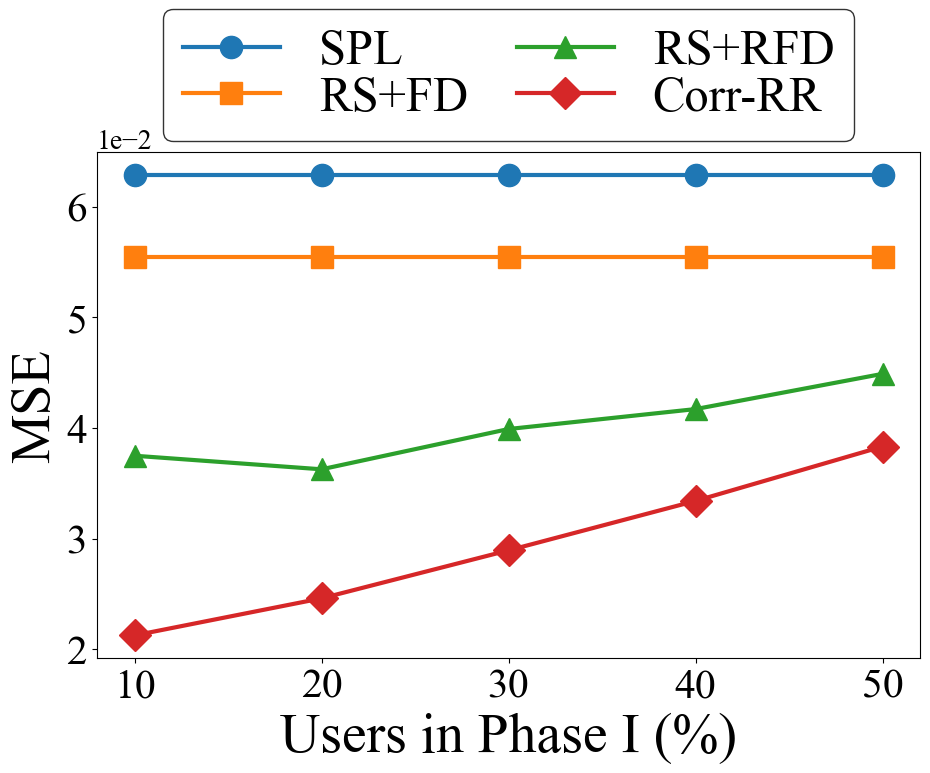

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.0628451 0.0628451 0.0628451 0.0628451 0.0628451]
RS+FD MSE = [0.05544204 0.05544204 0.05544204 0.05544204 0.05544204]
RS+RFD MSE = [0.03747927 0.03625295 0.03989328 0.04169492 0.04487835]
Corr-RR MSE = [0.02124393 0.02459378 0.02892888 0.03339725 0.0383123 ]


In [94]:
means = sweep_vs_phase1(
    n=2000,
    epsilon=0.3,            # pick the ε you want to hold fixed
    R=200,
    corr=0.9,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
    csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


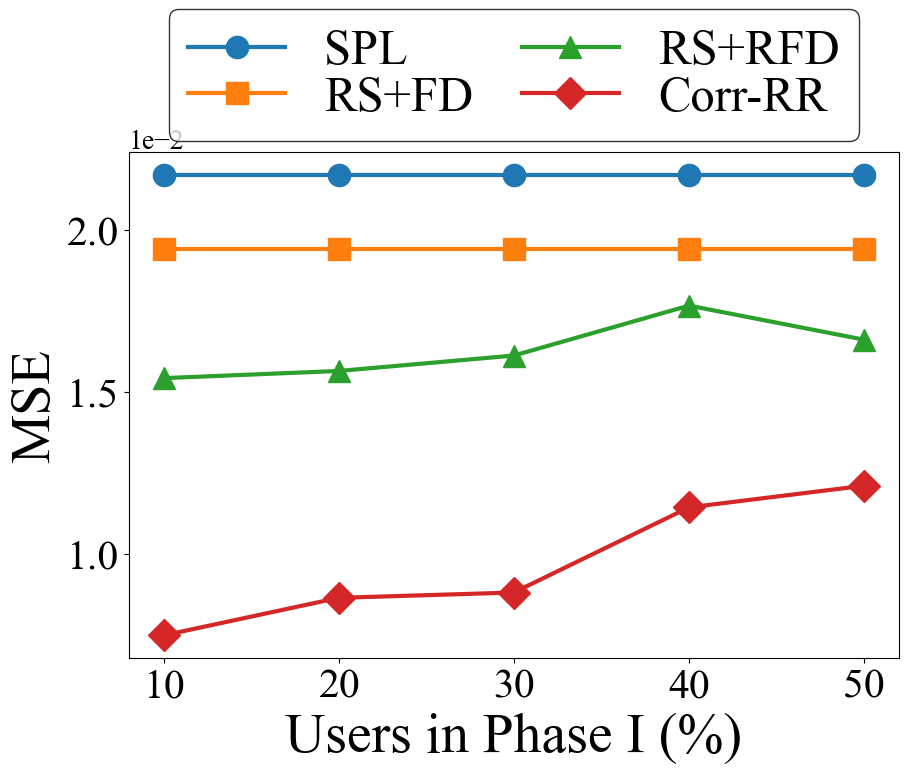

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.02169115 0.02169115 0.02169115 0.02169115 0.02169115]
RS+FD MSE = [0.01940747 0.01940747 0.01940747 0.01940747 0.01940747]
RS+RFD MSE = [0.01541704 0.01563874 0.01611444 0.0176578  0.01660424]
Corr-RR MSE = [0.00747043 0.0086308  0.00879564 0.01142451 0.01209455]


In [95]:
means = sweep_vs_phase1(
    n=2000,
    epsilon=0.5,            # pick the ε you want to hold fixed
    R=200,
    corr=0.9,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
    csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


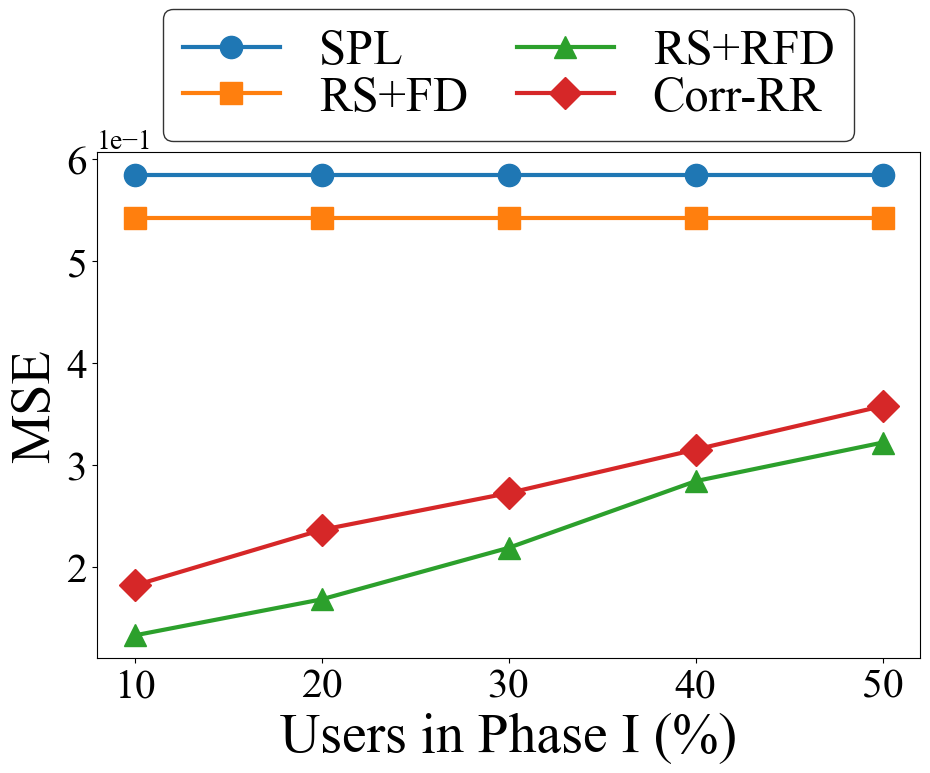

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.58403325 0.58403325 0.58403325 0.58403325 0.58403325]
RS+FD MSE = [0.54226207 0.54226207 0.54226207 0.54226207 0.54226207]
RS+RFD MSE = [0.13288515 0.16820441 0.21869691 0.28403372 0.32185891]
Corr-RR MSE = [0.18181448 0.23628623 0.27236772 0.31501637 0.35767529]


In [96]:
means = sweep_vs_phase1(
    n=2000,
    epsilon=0.1,            # pick the ε you want to hold fixed
    R=200,
    corr=0.1,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
    csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


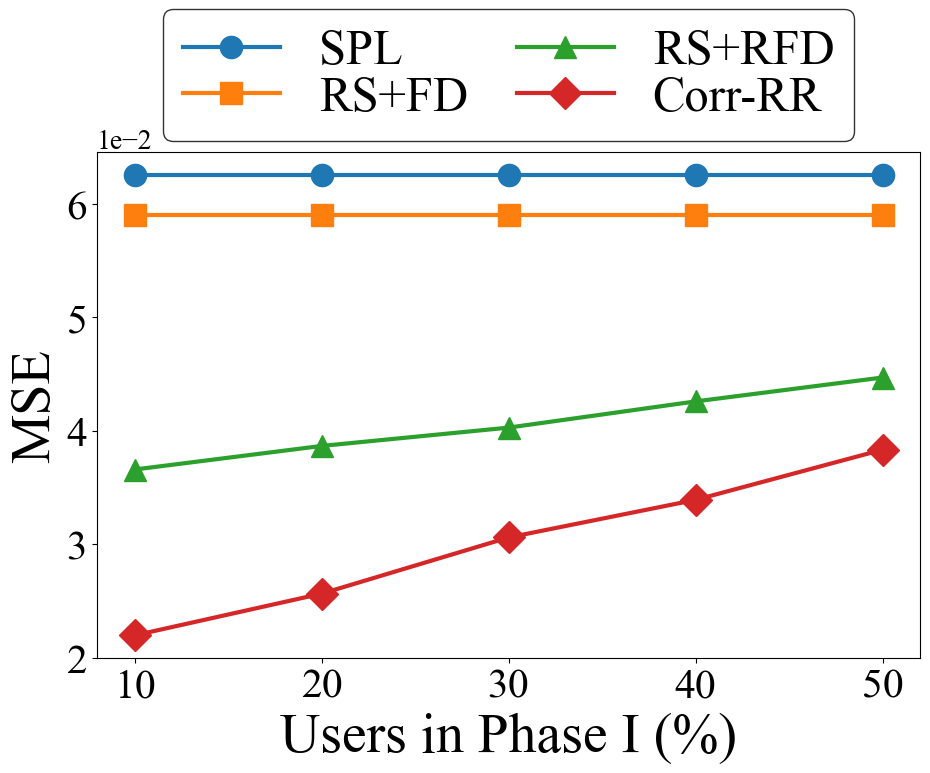

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.06254909 0.06254909 0.06254909 0.06254909 0.06254909]
RS+FD MSE = [0.05900034 0.05900034 0.05900034 0.05900034 0.05900034]
RS+RFD MSE = [0.03658936 0.03866813 0.04028357 0.04259376 0.04470004]
Corr-RR MSE = [0.02196699 0.02564585 0.03059921 0.03391411 0.03833772]


In [97]:
means = sweep_vs_phase1(
    n=2000,
    epsilon=0.3,            # pick the ε you want to hold fixed
    R=200,
    corr=0.1,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
    csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


In [98]:
means = sweep_vs_phase1(
    n=2000,
    epsilon=0.5,            # pick the ε you want to hold fixed
    R=200,
    corr=0.1,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
    csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


KeyboardInterrupt: 

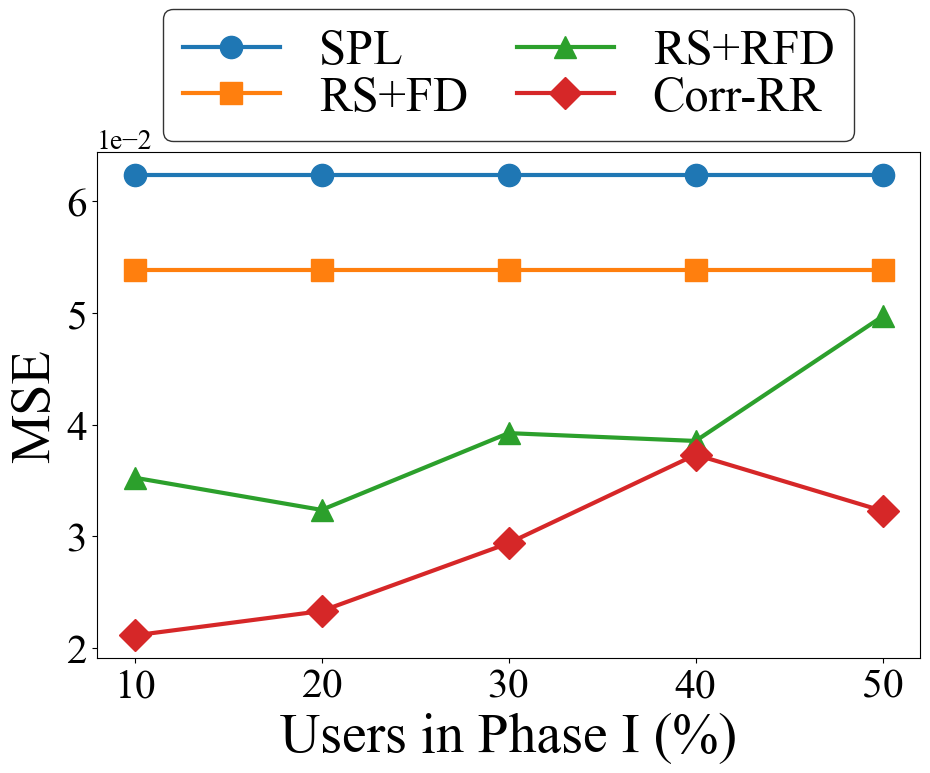

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.06232064 0.06232064 0.06232064 0.06232064 0.06232064]
RS+FD MSE = [0.05382789 0.05382789 0.05382789 0.05382789 0.05382789]
RS+RFD MSE = [0.03524486 0.03236125 0.03923021 0.03852972 0.04967656]
Corr-RR MSE = [0.02113404 0.02331277 0.02938327 0.0373002  0.03227289]


In [90]:
means = sweep_vs_phase1(
    n=20000,
    epsilon=0.1,            # pick the ε you want to hold fixed
    R=50,
    corr=0.1,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
    csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


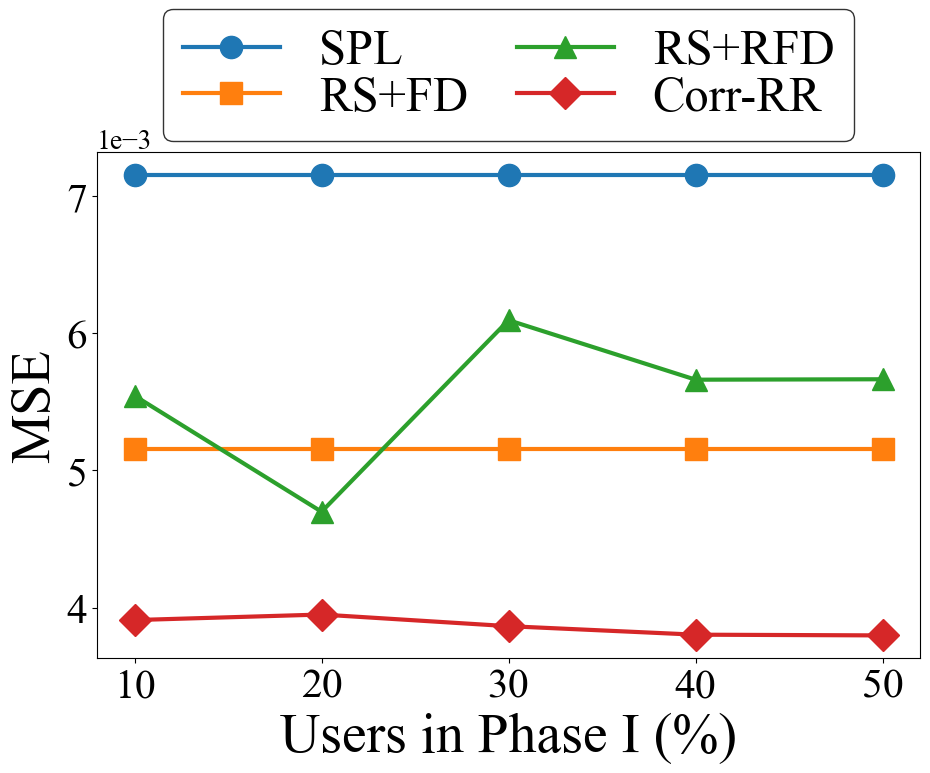

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.00715155 0.00715155 0.00715155 0.00715155 0.00715155]
RS+FD MSE = [0.00515539 0.00515539 0.00515539 0.00515539 0.00515539]
RS+RFD MSE = [0.0055432  0.00469804 0.00609366 0.00566023 0.00566336]
Corr-RR MSE = [0.00390871 0.00394909 0.0038642  0.00380224 0.00379695]


In [91]:
means = sweep_vs_phase1(
    n=20000,
    epsilon=0.3,            # pick the ε you want to hold fixed
    R=50,
    corr=0.1,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
    csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)


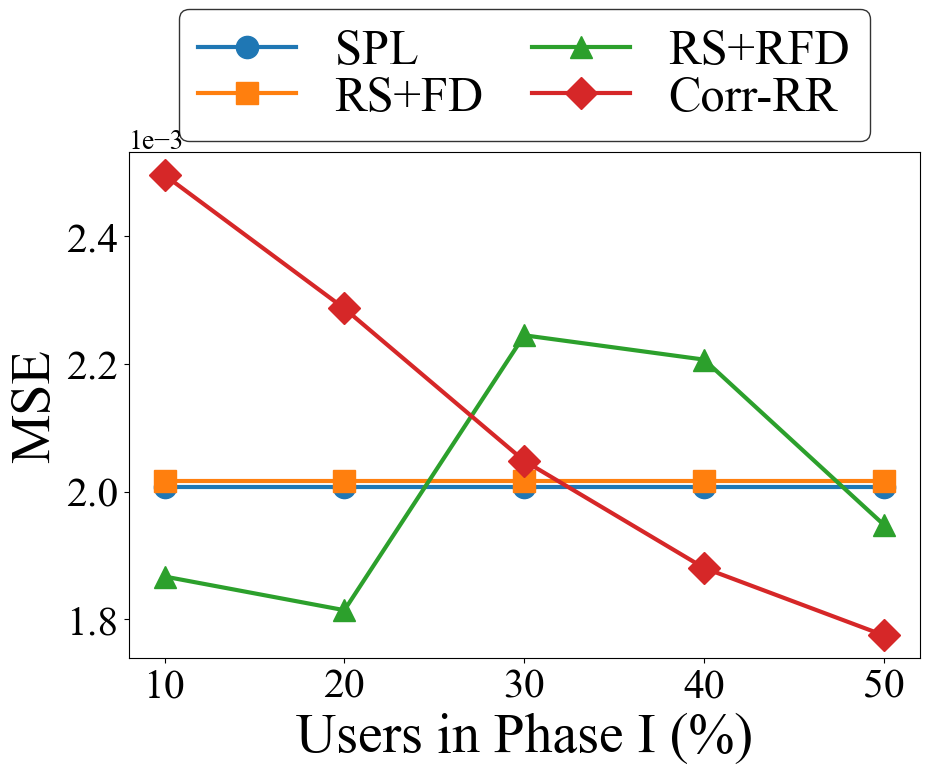

Users in Phase I (%) = [10, 20, 30, 40, 50]
SPL MSE = [0.00200714 0.00200714 0.00200714 0.00200714 0.00200714]
RS+FD MSE = [0.00201715 0.00201715 0.00201715 0.00201715 0.00201715]
RS+RFD MSE = [0.00186683 0.00181402 0.0022448  0.00220664 0.00194764]
Corr-RR MSE = [0.00249593 0.0022868  0.00204805 0.00188016 0.00177453]


In [92]:
means = sweep_vs_phase1(
    n=20000,
    epsilon=0.5,            # pick the ε you want to hold fixed
    R=50,
    corr=0.1,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
    csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
)
